In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =2e-20

nband = 120

ng =7

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 1000

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 980

data w_diffuse
     &     /1.6 , 1.75 , 1.55 , 1.66,
     &     1.7 , 1.75 , 1.8/

data wgt
     &     /0.35 , 0.6 , 0.5 , 0.55,
     &     0.7 , 0.9 , 1.0/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

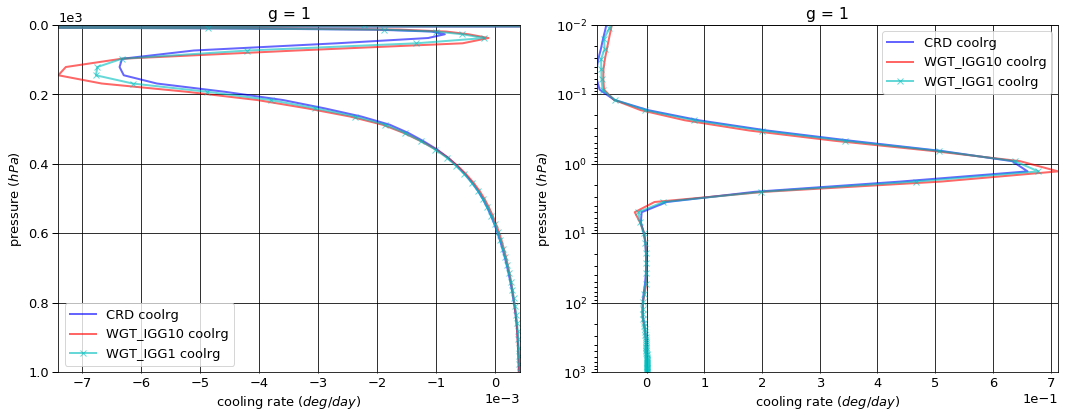

# Figure: cooling rate g-group 2

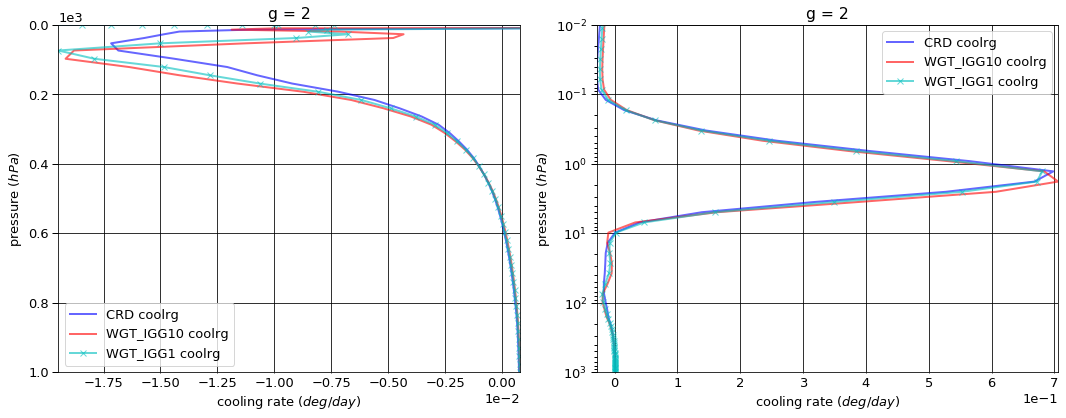

# Figure: cooling rate g-group 3

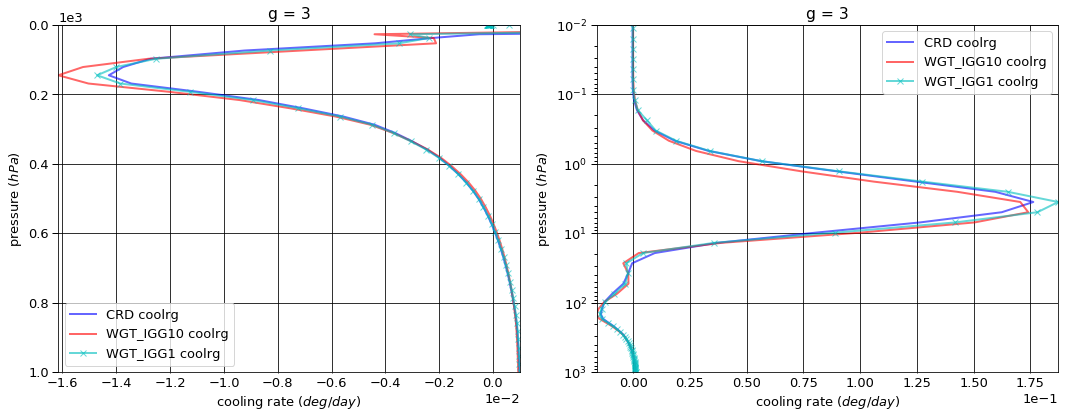

# Figure: cooling rate g-group 4

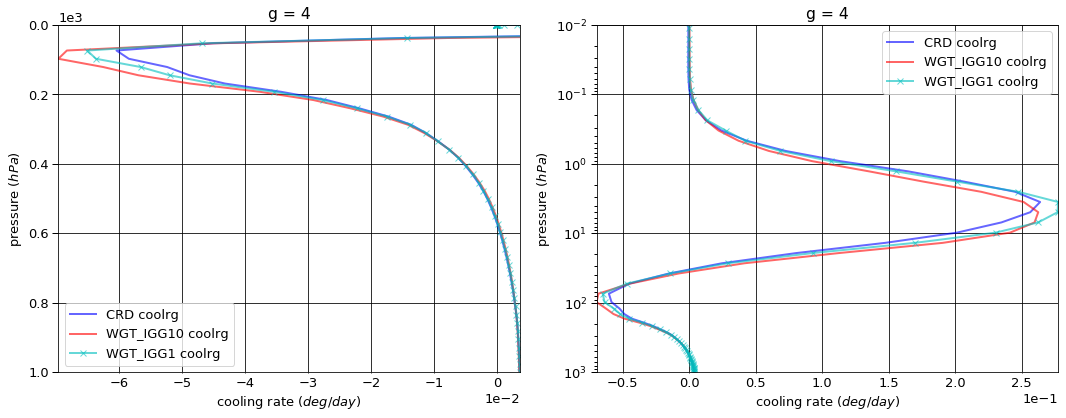

# Figure: cooling rate g-group 5

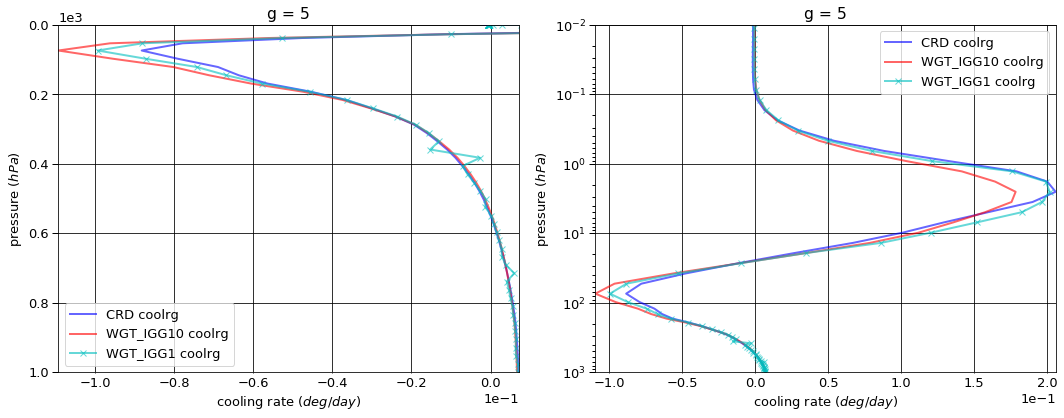

# Figure: cooling rate g-group 6

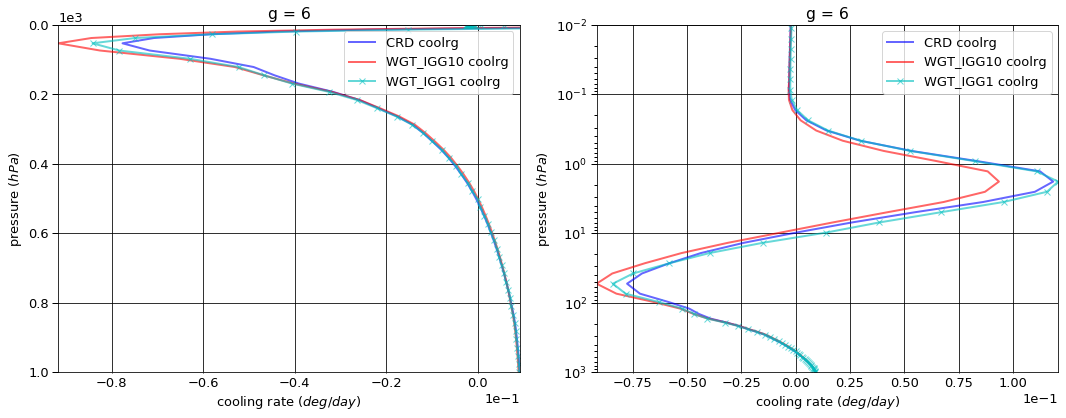

# Figure: cooling rate g-group 7

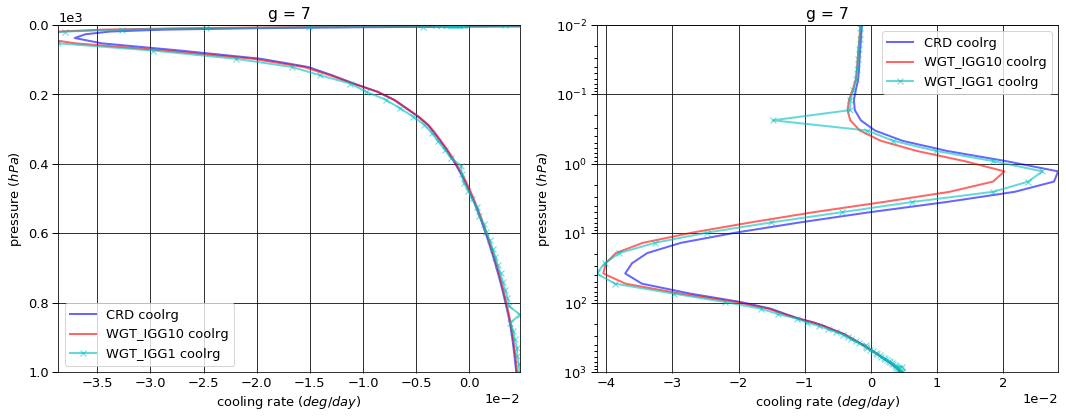

# Figure: cooling rate g-group total

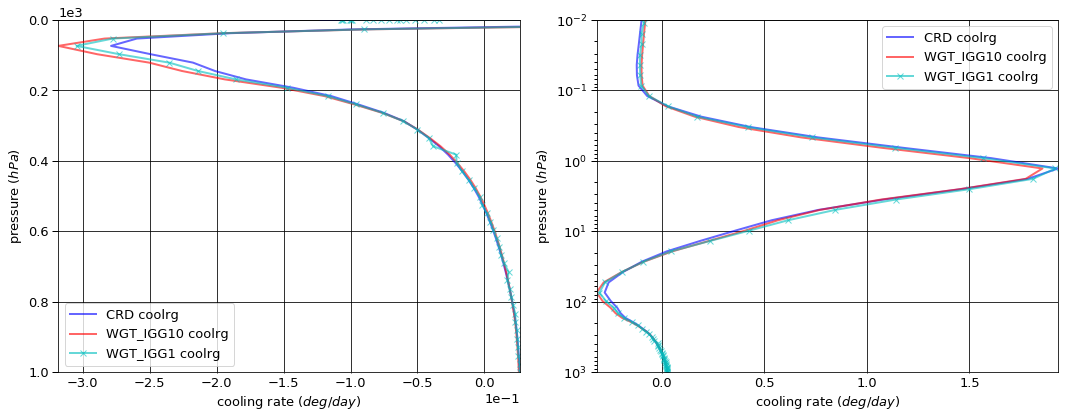

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.122630  0.000000  -0.122630
  1013.0   76     -0.219834  0.083540  -0.136294
2 0.0      1      -0.241169  0.000000  -0.241169
  1013.0   76     -0.487162  0.163658  -0.323503
3 0.0      1      -0.174546  0.000000  -0.174546
  1013.0   76     -0.497804  0.198411  -0.299393
4 0.0      1      -0.588586  0.000000  -0.588586
  1013.0   76     -2.065825  0.732113  -1.333713
5 0.0      1      -1.747014  0.000000  -1.747014
  1013.0   76     -4.446029  1.310135  -3.135894
6 0.0      1      -4.888711  0.000000  -4.888711
  1013.0   76     -7.386412  1.343643  -6.042769
7 0.0      1     -15.317434  0.000000 -15.317434
  1013.0   76    -16.251171  0.534472 -15.716699


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.126778  0.000000  -0.126778
  1013.0   76     -0.219834  0.081653  -0.138182
2 0.0      1      -0.247374  0.000000  -0.247374
  1013.0   76     -0.487162  0.161385  -0.325777
3 0.0      1      -0.175994  0.000000  -0.175994
  1013.0   76     -0.497804  0.190590  -0.307214
4 0.0      1      -0.562579  0.000000  -0.562579
  1013.0   76     -2.065825  0.713223  -1.352602
5 0.0      1      -1.558717  0.000000  -1.558717
  1013.0   76     -4.446029  1.283823  -3.162206
6 0.0      1      -4.752646  0.000000  -4.752646
  1013.0   76     -7.386412  1.335249  -6.051163
7 0.0      1     -15.280973  0.000000 -15.280973
  1013.0   76    -16.251171  0.539151 -15.712020


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.124379  0.000000  -0.124379
  1013.0   76     -0.219834  0.084526  -0.135308
2 0.0      1      -0.242277  0.000000  -0.242277
  1013.0   76     -0.487162  0.162742  -0.324419
3 0.0      1      -0.178543  0.000000  -0.178543
  1013.0   76     -0.497804  0.199544  -0.298260
4 0.0      1      -0.581081  0.000000  -0.581081
  1013.0   76     -2.065825  0.730427  -1.335398
5 0.0      1      -1.704621  0.000000  -1.704621
  1013.0   76     -4.446029  1.284253  -3.161776
6 0.0      1      -4.837823  0.000000  -4.837823
  1013.0   76     -7.386412  1.340062  -6.046350
7 0.0      1     -15.231159  0.000000 -15.231159
  1013.0   76    -16.251171  0.572038 -15.679133


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -4.148260e-03  0.000000 -0.004148
  1013.0   76     2.775558e-17 -0.001887 -0.001887
2 0.0      1     -6.205370e-03  0.000000 -0.006205
  1013.0   76     0.000000e+00 -0.002273 -0.002273
3 0.0      1     -1.447800e-03  0.000000 -0.001448
  1013.0   76     0.000000e+00 -0.007821 -0.007821
4 0.0      1      2.600669e-02  0.000000  0.026007
  1013.0   76     0.000000e+00 -0.018890 -0.018890
5 0.0      1      1.882969e-01  0.000000  0.188297
  1013.0   76     0.000000e+00 -0.026312 -0.026312
6 0.0      1      1.360655e-01  0.000000  0.136065
  1013.0   76     0.000000e+00 -0.008394 -0.008394
7 0.0      1      3.646100e-02  0.000000  0.036461
  1013.0   76     0.000000e+00  0.004679  0.004679


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -1.748890e-03  0.000000 -0.001749
  1013.0   76     2.775558e-17  0.000986  0.000986
2 0.0      1     -1.108400e-03  0.000000 -0.001108
  1013.0   76     0.000000e+00 -0.000916 -0.000916
3 0.0      1     -3.997160e-03  0.000000 -0.003997
  1013.0   76     0.000000e+00  0.001133  0.001133
4 0.0      1      7.505030e-03  0.000000  0.007505
  1013.0   76     0.000000e+00 -0.001686 -0.001686
5 0.0      1      4.239300e-02  0.000000  0.042393
  1013.0   76     0.000000e+00 -0.025882 -0.025882
6 0.0      1      5.088850e-02  0.000000  0.050888
  1013.0   76     0.000000e+00 -0.003581 -0.003581
7 0.0      1      8.627500e-02  0.000000  0.086275
  1013.0   76     0.000000e+00  0.037566  0.037566

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.028749
  1001.112500 75     0.000409
2 0.000312    1     -0.008853
  1001.112500 75     0.000751
3 0.000312    1     -0.000107
  1001.112500 75     0.000984
4 0.000312    1     -0.000246
  1001.112500 75     0.003597
5 0.000312    1     -0.000586
  1001.112500 75     0.007108
6 0.000312    1     -0.000808
  1001.112500 75     0.009171
7 0.000312    1     -0.000422
  1001.112500 75     0.004427


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.022912
  1001.112500 75     0.000400
2 0.000312    1     -0.006275
  1001.112500 75     0.000784
3 0.000312    1     -0.000040
  1001.112500 75     0.000939
4 0.000312    1     -0.000018
  1001.112500 75     0.003523
5 0.000312    1     -0.000208
  1001.112500 75     0.006719
6 0.000312    1     -0.000765
  1001.112500 75     0.008906
7 0.000312    1     -0.000524
  1001.112500 75     0.004509


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.024576
  1001.112500 75     0.000420
2 0.000312    1     -0.007375
  1001.112500 75     0.000777
3 0.000312    1     -0.000076
  1001.112500 75     0.001000
4 0.000312    1     -0.000095
  1001.112500 75     0.003619
5 0.000312    1     -0.000292
  1001.112500 75     0.006889
6 0.000312    1     -0.000689
  1001.112500 75     0.009039
7 0.000312    1     -0.000519
  1001.112500 75     0.004730


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.005837
  1001.112500 75    -0.000009
2 0.000312    1      0.002578
  1001.112500 75     0.000033
3 0.000312    1      0.000067
  1001.112500 75    -0.000045
4 0.000312    1      0.000228
  1001.112500 75    -0.000074
5 0.000312    1      0.000379
  1001.112500 75    -0.000389
6 0.000312    1      0.000043
  1001.112500 75    -0.000265
7 0.000312    1     -0.000101
  1001.112500 75     0.000081


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.004172
  1001.112500 75     0.000011
2 0.000312    1      0.001477
  1001.112500 75     0.000026
3 0.000312    1      0.000032
  1001.112500 75     0.000015
4 0.000312    1      0.000151
  1001.112500 75     0.000022
5 0.000312    1      0.000294
  1001.112500 75    -0.000219
6 0.000312    1      0.000119
  1001.112500 75    -0.000132
7 0.000312    1     -0.000097
  1001.112500 75     0.000302

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.080089,0.000000,-23.080089
1013.0,76,-31.354237,4.365971,-26.988265



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.705060,0.000000,-22.705060
1013.0,76,-31.354237,4.305074,-27.049164



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.899882,0.000000,-22.899882
1013.0,76,-31.354237,4.373592,-26.980645



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.375029,0.000000,0.375029
1013.0,76,0.000000,-0.060898,-0.060898



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.180207,0.00000,0.180207
1013.0,76,0.000000,0.00762,0.007620


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.039772
1001.112500,75,0.026448



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.030741
1001.112500,75,0.025780



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.033623
1001.112500,75,0.026474



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.009031
1001.112500,75,-0.000668



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.006149
1001.112500,75,0.000026


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.007008,0.007001
2,0.015458,0.015548
3,0.015917,0.015833
4,0.065800,0.065818
5,0.140908,0.141961
6,0.232192,0.236740
7,0.522717,0.517099


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.107750e-18
2,7.729691e-19
3,1.023108e-18
4,2.756166e-19
5,7.424874e-20
6,2.000197e-20
7,1.116904e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.107750e-18,NaN,0.007008,0.007001,0.007008,0.007001,1.0
2,7.729691e-19,0.151333,0.015458,0.015548,0.022467,0.022549,1.0
3,1.023108e-18,1.323608,0.015917,0.015833,0.038383,0.038382,50.0
4,2.756166e-19,0.269391,0.065800,0.065818,0.104183,0.104200,50.0
5,7.424874e-20,0.269391,0.140908,0.141961,0.245092,0.246161,50.0
6,2.000197e-20,0.269391,0.232192,0.236740,0.477283,0.482901,50.0
7,1.116904e-22,0.005584,0.522717,0.517099,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.255242e-17  9.587483e-18   1.309251  1.522357e-05
      2 0.000312     1.784460e-18  1.181174e-18   1.510751  2.210985e-06
      3 0.000312     2.969447e-20  2.773876e-20   1.070505  4.114453e-08
      4 0.000312     2.607850e-20  1.869461e-20   1.394974  3.260393e-08
      5 0.000312     1.925459e-20  8.367077e-21   2.301233  2.290773e-08
      6 0.000312     8.572114e-21  3.384094e-21   2.533060  1.153861e-08
      7 0.000312     1.359026e-21  5.055131e-23  26.884094  1.947182e-09
2     1 0.000750     1.254344e-17  9.587544e-18   1.308306  6.875375e-06
      2 0.000750     1.786784e-18  1.183380e-18   1.509899  1.000306e-06
      3 0.000750     2.987813e-20  2.790770e-20   1.070605  1.870153e-08
      4 0.000750     2.618209e-20  1.875888e-20   1.395717  1.478472e-08
      5 0.000750     1.932269e-20  8.386182e-21   2.304110  1.038334e-08
      6 0.000750     8.601231e-21  3.392025e-21   2.535721  5.230145e-09
      7 0.000750     1.362691e-21  5.070778e-23  26.873409  8.820295e-10
3     1 0.001052     1.252490e-17  9.587769e-18   1.306342  1.172057e-05
      2 0.001052     1.791643e-18  1.187945e-18   1.508187  1.711493e-06
      3 0.001052     3.018809e-20  2.818943e-20   1.070901  3.222650e-08
      4 0.001052     2.638651e-20  1.888068e-20   1.397540  2.540348e-08
      5 0.001052     1.946572e-20  8.424259e-21   2.310674  1.783439e-08
      6 0.001052     8.663055e-21  3.408264e-21   2.541779  8.984473e-09
      7 0.001052     1.370497e-21  5.098087e-23  26.882575  1.513128e-09
4     1 0.001476     1.250515e-17  9.587838e-18   1.304272  1.937451e-05
      2 0.001476     1.796791e-18  1.192794e-18   1.506371  2.840172e-06
      3 0.001476     3.053135e-20  2.850210e-20   1.071197  5.390497e-08
      4 0.001476     2.660681e-20  1.901242e-20   1.399443  4.234955e-08
      5 0.001476     1.961841e-20  8.465059e-21   2.317575  2.971750e-08
      6 0.001476     8.729124e-21  3.425604e-21   2.548200  1.497302e-08
      7 0.001476     1.378871e-21  5.128118e-23  26.888435  2.518165e-09
5     1 0.002070     1.248521e-17  9.587713e-18   1.302210  3.129949e-05
      2 0.002070     1.801951e-18  1.197675e-18   1.504542  4.606252e-06
      3 0.002070     3.089857e-20  2.883777e-20   1.071462  8.817891e-08
      4 0.002070     2.683292e-20  1.914866e-20   1.401295  6.900932e-08
      5 0.002070     1.977276e-20  8.506657e-21   2.324387  4.839636e-08
      6 0.002070     8.795930e-21  3.443177e-21   2.554597  2.438768e-08
      7 0.002070     1.387370e-21  5.159952e-23  26.887269  4.095892e-09
6     1 0.002904     1.246504e-17  9.587372e-18   1.300152  4.972215e-05
      2 0.002904     1.807127e-18  1.202594e-18   1.502691  7.346299e-06
      3 0.002904     3.129815e-20  2.920465e-20   1.071684  1.419752e-07
      4 0.002904     2.706644e-20  1.929089e-20   1.403069  1.106062e-07
      5 0.002904     1.992888e-20  8.549298e-21   2.331054  7.750787e-08
      6 0.002904     8.863455e-21  3.461039e-21   2.560923  3.906233e-08
      7 0.002904     1.395994e-21  5.194244e-23  26.875781  6.551649e-09
7     1 0.004074     1.244455e-17  9.586786e-18   1.298094  7.793284e-05
      2 0.004074     1.812327e-18  1.207569e-18   1.500806  1.156017e-05
      3 0.004074     3.174225e-20  2.961457e-20   1.071846  2.258293e-07
      4 0.004074     2.730982e-20  1.944137e-20   1.404727  1.749680e-07
      5 0.004074     2.008707e-20  8.593372e-21   2.337508  1.224824e-07
      6 0.004074     8.931755e-21  3.479288e-21   2.567121  6.173460e-08
      7 0.004074     1.404749e-21  5.231948e-23  26.849447  1.034061e-08
8     1 0.005714     1.242364e-17  9.585909e-18   1.296032  1.208258e-04
      2 0.005714     1.817563e-18  1.212623e-18   1.498869  1.799504e-05
      3 0.005714     3.224789e-20  3.008409e-20   1.071925  3.559519e-07
      4 0.005714     2.756655e-20  1.960328e-20   1.406222  2.739147e-07
      5 0.0

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
